# Analise para cartoleiros

## carrega pacotes

In [1]:
library(httr)
library(rjson)
library(jsonlite)
library(dplyr)
library(tidyr)
library(magrittr)
library(stringr)
library(lubridate)
library(tibble)
library(ggplot2)


Attaching package: ‘jsonlite’

The following objects are masked from ‘package:rjson’:

    fromJSON, toJSON


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## carrega dados

In [2]:
load("dados_cartola_2017_por_rodada.RData")
load("pontuacao_cartola.RData")

## carrega funções

In [3]:
ajuste_lag <- function(x){
  
  ifelse( is.na( x - lag(x) ) == TRUE, x, x - lag(x) )
  
}

## ajusta dados

In [4]:
dados_cartola_2017_por_rodada %<>%
  arrange( atleta_id, rodada_id ) %>%
  select( atleta_id, FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  group_by( atleta_id ) %>%
  mutate_all( funs( ajuste_lag(.) ) ) %>% 
  bind_cols( dados_cartola_2017_por_rodada %>%
               arrange( atleta_id, rodada_id ) %>% 
               select( -atleta_id, -FC, -PE, -RB, -SG, -CA, -FD, -FS, -FF, -I, -G, -DD, -GS, 
                       -A, -CV, -FT, -GC, -DP, -PP ), .) %>% 
  data.frame()

pontuacao_cartola %<>% 
  mutate( scout = as.character(scout) )


`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over all variables, use `mutate_all()`


## Obtenção do time

In [5]:
time <- "cartrolando"

json_time <- fromJSON( paste( readLines(
  paste0( "https://api.cartolafc.globo.com/times?q=", time)
  ), collapse = "" ) )

json_time %>% 
  data.frame() %>% 
  select( time_id,
          nome,
          nome_cartola,
          slug )

time_id,nome,nome_cartola,slug
10802037,Mustela Pretorio FC,Cartrolando,mustela-pretorio-fc
4518244,CartrolandoFC,CartrolandoFC,cartrolandofc
9168042,Cartrolando,Carleto Souza,cartrolando
4723933,Cartrolando F.Club,Maicon,cartrolando-f-club
3442902,Cartrolando FC,Well Fernandes,cartrolando-fc


## Obtenção dados do time

In [6]:
slug_time <- "cartrolando"

rodada_atual <- 6
dados_time_cartoleiro <- NULL

for( rodada in 2:rodada_atual ){
  
  # obtem o time
  json_time_dados <- fromJSON( paste( readLines(
    paste0("https://api.cartolafc.globo.com/time/slug/", slug_time, "/", rodada)
  ), collapse = "" ) )
  
  dados_rodada <- dados_cartola_2017_por_rodada %>% 
    filter( rodada_id == rodada)
  
  temp_time <- json_time_dados$atletas[1:13] %>% 
    select( atleta_id ) %>%
    right_join(., x = dados_rodada, by = "atleta_id" ) %>% 
    select( apelido, 
            clube, 
            posicao,
            rodada_id,
            pontos_num, 
            media_num,
            preco_num,
            variacao_num,
            FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP,
            partidas.clube_casa_nome,
            partidas.clube_casa_posicao,
            partidas.clube_visitante_nome,
            partidas.clube_visitante_posicao,
            mandante)
  
  dados_time_cartoleiro <- rbind( dados_time_cartoleiro,
                                  temp_time )
  
}

# Analise da rodada

## Time utilizado

In [7]:
rodada <- 6
dados_time_cartoleiro %>%
  filter(rodada_id == rodada ) %>% 
  select( clube, apelido, posicao, pontos_num ) %>% 
  arrange( posicao )

clube,apelido,posicao,pontos_num
Vasco,Luis Fabiano,ata,8.90
Coritiba,Wilson,gol,2.00
Cruzeiro,Diogo Barbosa,lat,5.30
Chapecoense,Apodi,lat,-5.10
Bahia,Renê Júnior,mei,6.50
Cruzeiro,Ariel Cabral,mei,0.20
Botafogo,Bruno Silva,mei,2.70
Corinthians,Maycon,mei,4.20
Chapecoense,Moisés,mei,3.10
Corinthians,Fábio Carille,tec,4.01


## Esquema tático utilizado

In [8]:
dados_time_cartoleiro %>% 
  mutate( pos_gerais = ifelse( posicao == "lat" | posicao == "zag", "zag", posicao ) ) %>% 
  group_by( rodada_id ) %>% 
  count( pos_gerais ) %>% 
  filter( !pos_gerais %in% c("gol", "tec"),
          rodada_id == rodada )

rodada_id,pos_gerais,n
6,ata,1
6,mei,5
6,zag,4


## Pontuação por posição

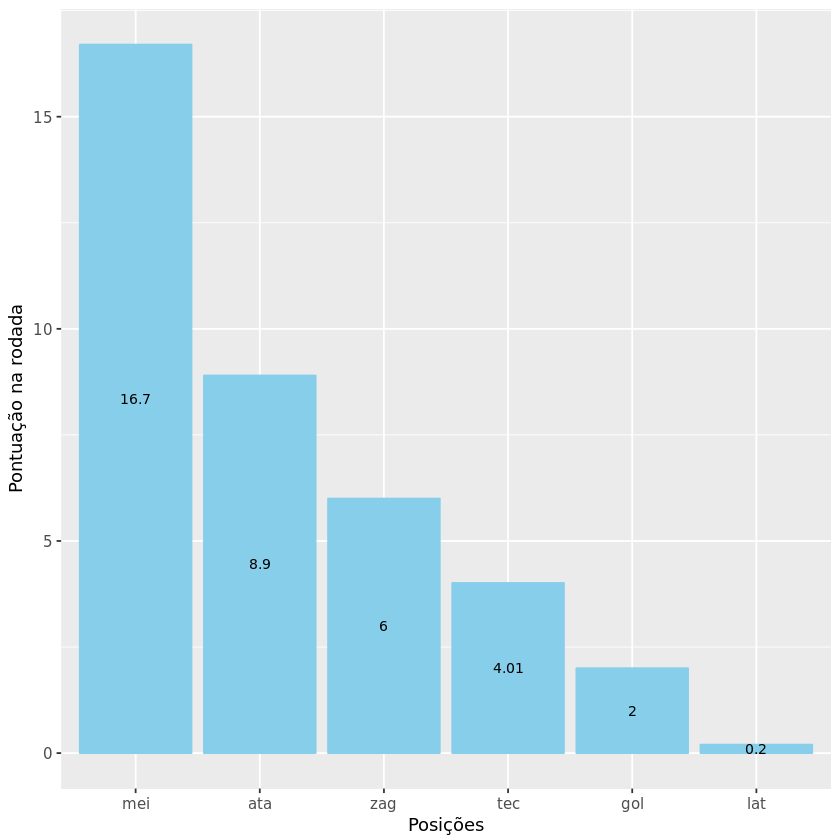

In [9]:
dados_time_cartoleiro %>% 
  filter( rodada_id == rodada ) %>% 
  group_by( posicao ) %>% 
  summarise( pontuacao = sum(pontos_num) ) %>% 
  ggplot( aes( x = reorder( posicao, -pontuacao), y = pontuacao, label = pontuacao ) ) +
  geom_bar( stat = "identity", color = "sky blue", fill = "sky blue" ) +
  geom_text( size = 3, position = position_stack(vjust = 0.5) ) +
  ylab( "Pontuação na rodada" ) +
  xlab( "Posições" )

## Scouts da rodada

Legenda:

Roubada de bola (RB)  
Falta cometida (FC)  
Gol contra (GC)  
Cartão amarelo (CA)  
Cartão vermelho (CV)  
Jogo sem sofrer gol (SG)  
Defesa difícil (DD)  
Defesa de pênalti (DP)  
Gol sofrido (GS)  
Falta sofrida (FS)  
Passe errado (PE)  
Assistência (A)  
Finalização na trave (FT)  
Finalização defendida (FD)  
Finalização para fora (FF)  
Gol (G)  
Impedimento (I)  
Pênalti perdido (PP)  

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`


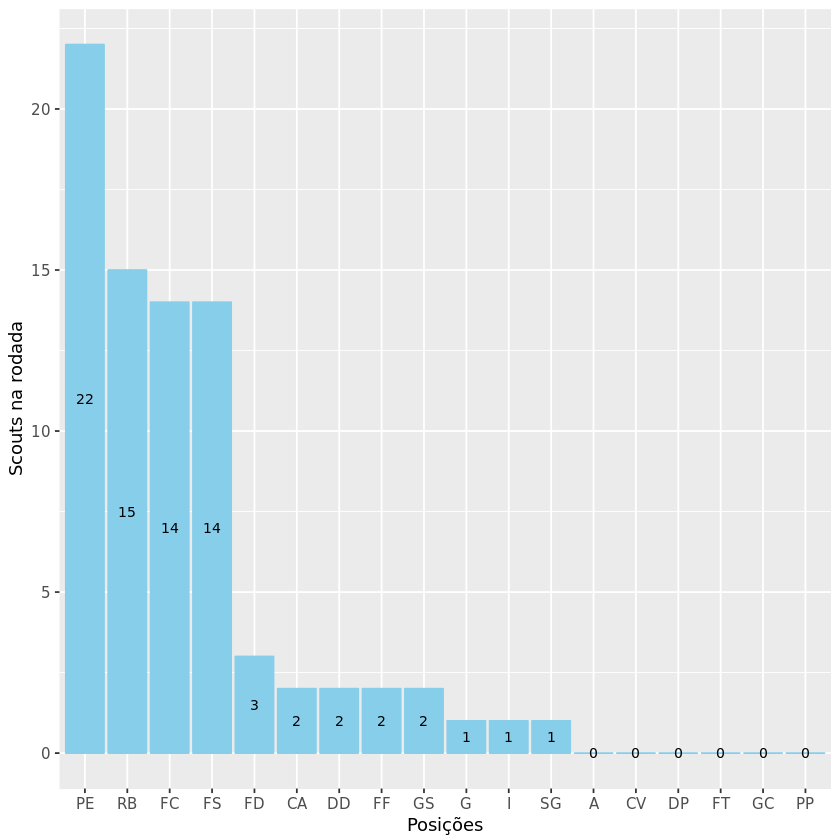

In [10]:
dados_time_cartoleiro %>% 
  filter( rodada_id == rodada ) %>% 
  select( FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  summarise_all( funs(sum) ) %>%
  gather( key = scout, value = qtd_scouts ) %>% 
  ggplot( aes( x = reorder( scout, -qtd_scouts), y = qtd_scouts, label = qtd_scouts ) ) +
  geom_bar( stat = "identity", color = "sky blue", fill = "sky blue" ) +
  geom_text( size = 3, position = position_stack(vjust = 0.5) ) +
  ylab( "Scouts na rodada" ) +
  xlab( "Posições" )


## Scouts por posição

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`
`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`
`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`


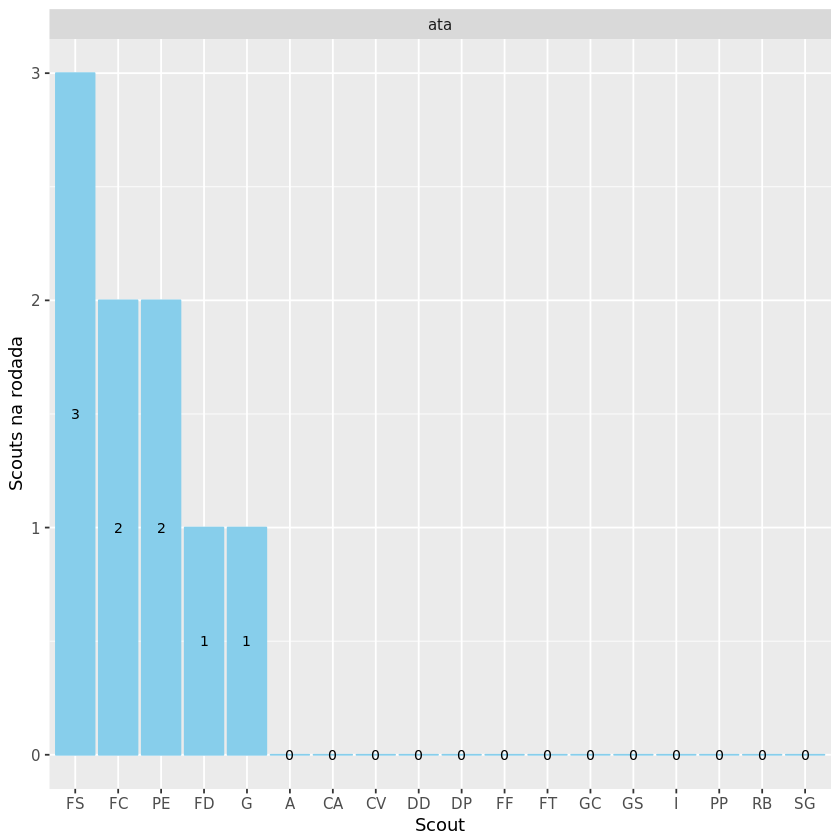

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`


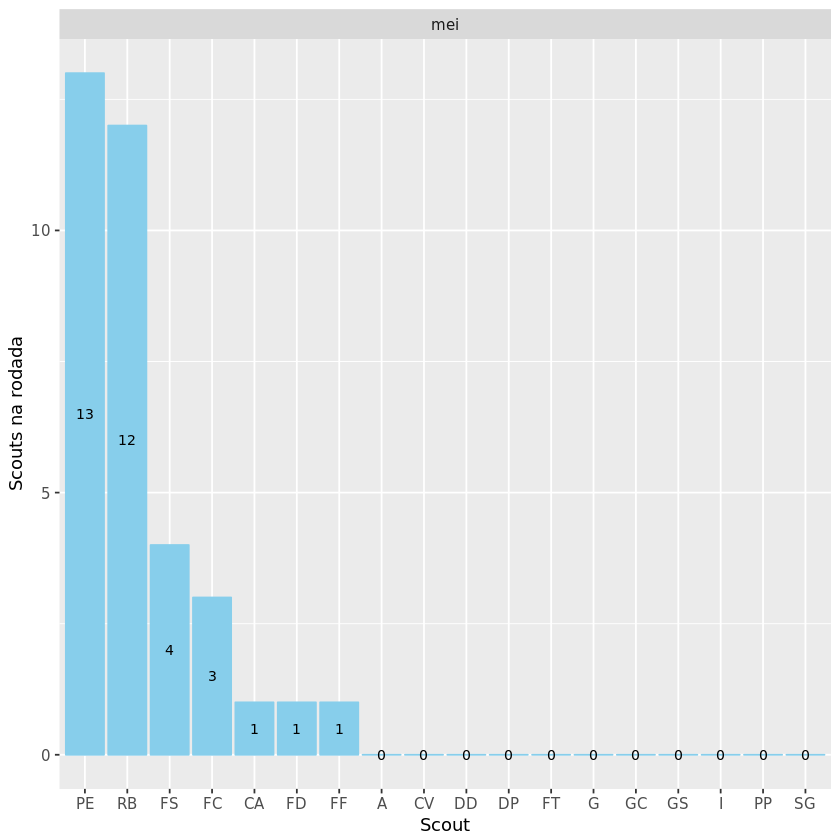

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`


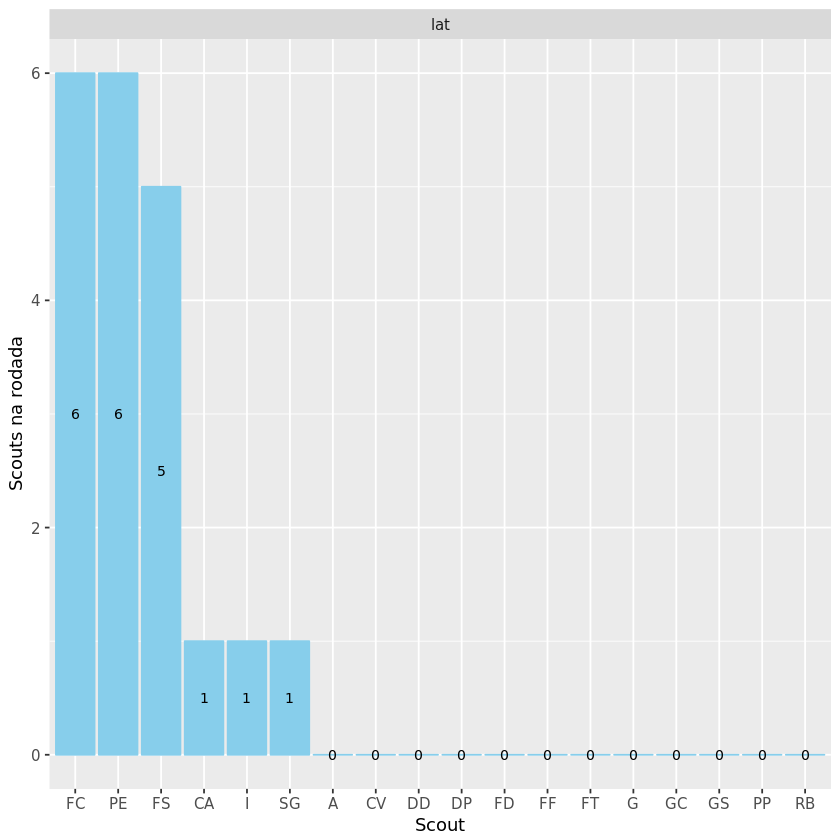

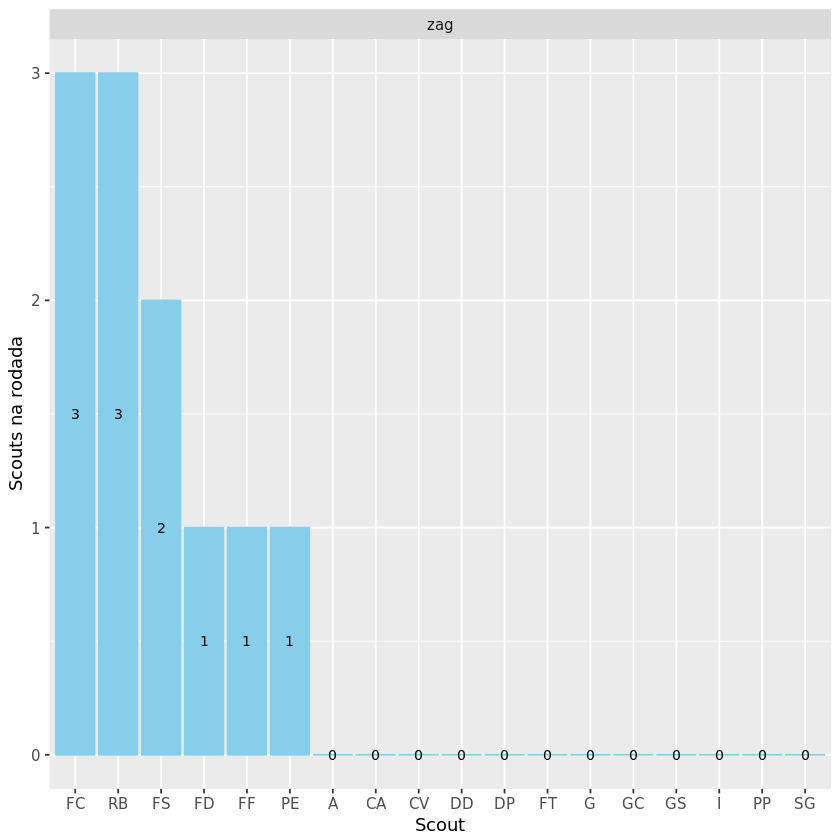

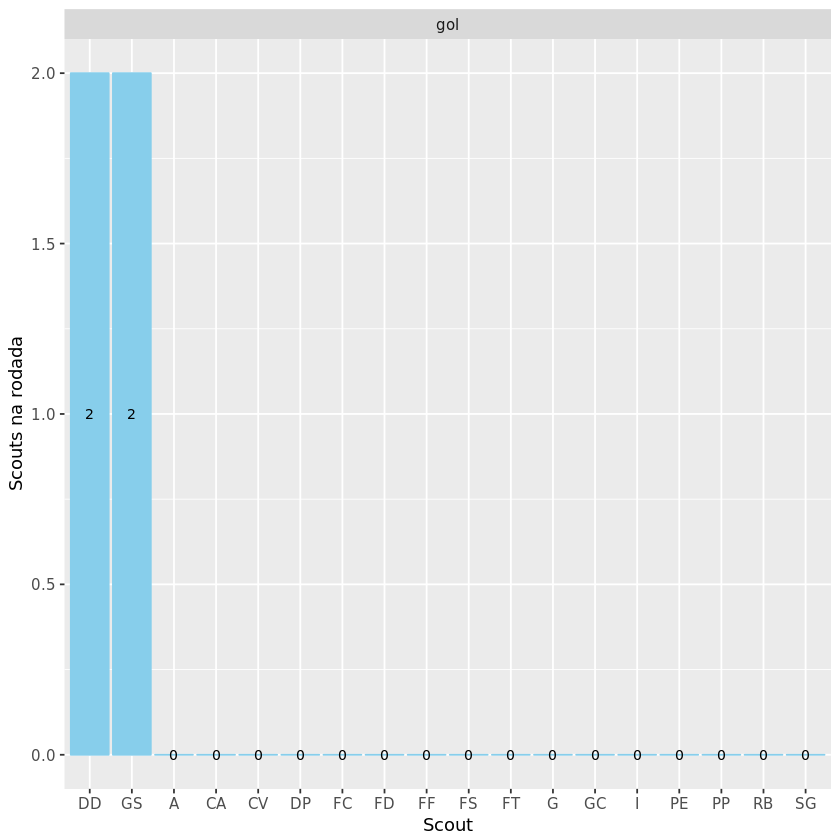

In [11]:
posics <- c("ata", "mei", "lat", "zag", "gol")

for( pos in posics ){
    
print( dados_time_cartoleiro %>% 
  filter( rodada_id == rodada ) %>% 
  select( posicao, FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  group_by( posicao) %>% 
  summarise_each( funs(sum) ) %>% 
  filter( posicao == pos ) %>% 
  gather( key = scout, value = qtd_scouts, -posicao) %>% 
  ggplot( aes( x = reorder( scout, -qtd_scouts ) , y = qtd_scouts, label = qtd_scouts ) ) +
  geom_bar( stat = "identity",  color = "sky blue", fill = "sky blue" ) + 
  geom_text( size = 3, position = position_stack(vjust = 0.5) ) +
  facet_wrap(~posicao) +
  ylab( "Scouts na rodada" ) +
  xlab( "Scout" ) )
    
}

## Onde ganhou pontos

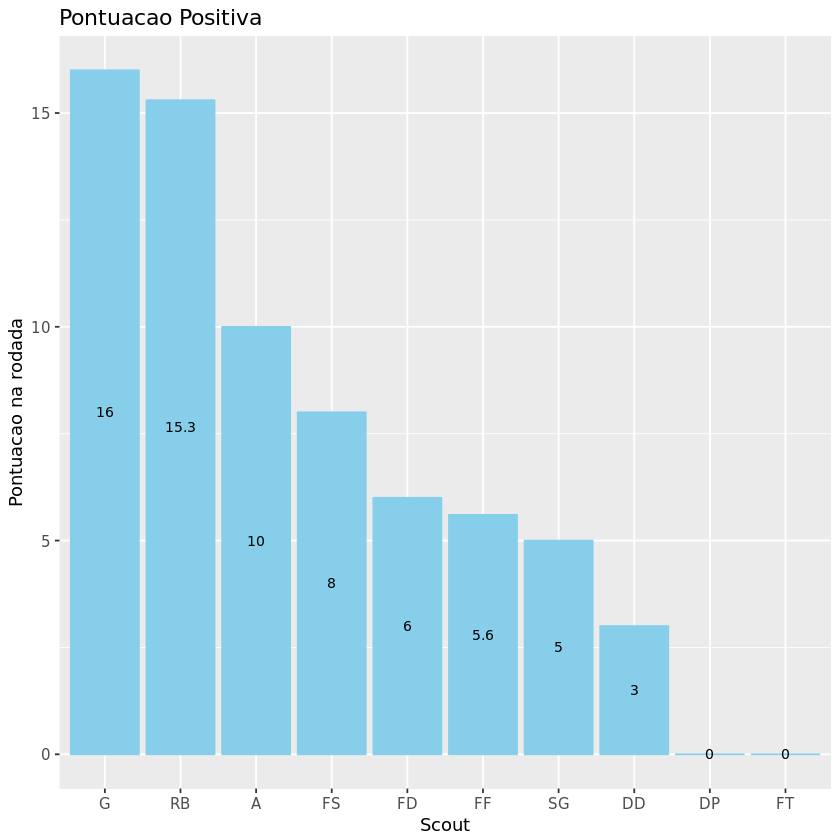

In [17]:
dados_time_cartoleiro %>% 
  filter( rodada_id == rodada ) %>% 
  select( FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  summarise_each( funs(sum) ) %>% 
  gather( key = scout, value = qtd ) %>% 
  right_join(., x = pontuacao_cartola, by = "scout" ) %>% 
  mutate( pontos_por_scout = qtd * valor ) %>% 
  filter( valor > 0 ) %>% 
  ggplot( aes( x = reorder( scout, -pontos_por_scout), y = pontos_por_scout, label = pontos_por_scout ) ) +
  geom_bar( stat = "identity",  color = "sky blue", fill = "sky blue" ) +
  geom_text( size = 3, position = position_stack(vjust = 0.5) ) +
  ylab( "Pontuacao na rodada" ) +
  xlab( "Scout" ) +
  ggtitle( "Pontuaçãbo Positiva" )

## Onde perdeu pontos

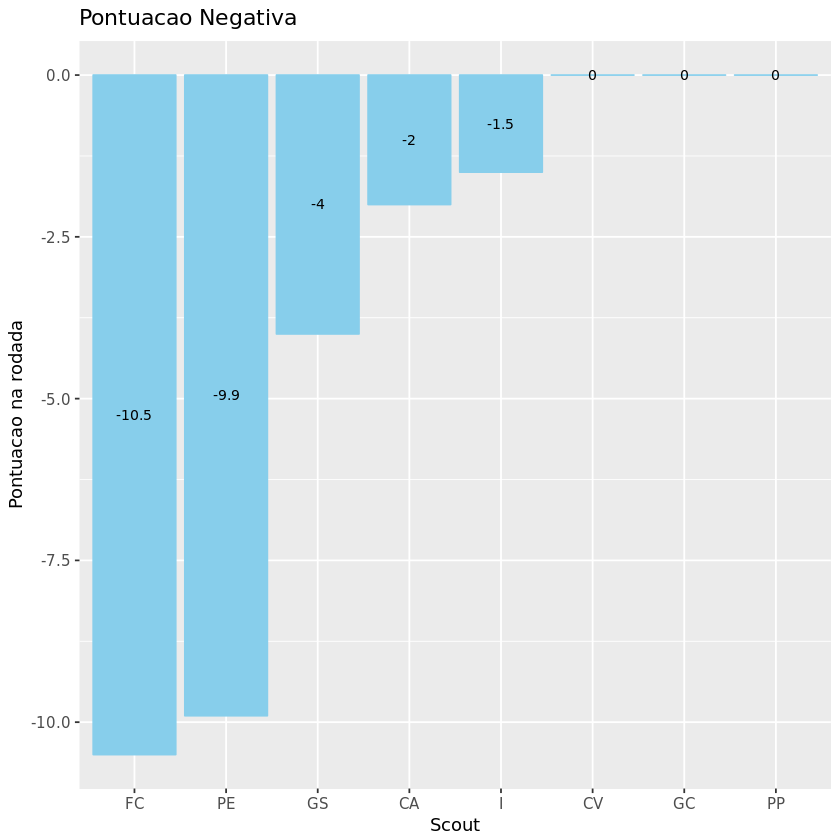

In [18]:
dados_time_cartoleiro %>% 
  filter( rodada_id == rodada ) %>% 
  select( FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  summarise_each( funs(sum) ) %>% 
  gather( key = scout, value = qtd ) %>% 
  right_join(., x = pontuacao_cartola, by = "scout" ) %>% 
  mutate( pontos_por_scout = qtd * valor ) %>% 
  filter( valor < 0 ) %>% 
  ggplot( aes( x = reorder( scout, pontos_por_scout), y = pontos_por_scout, label = pontos_por_scout ) ) +
  geom_bar( stat = "identity", color = "sky blue", fill = "sky blue" ) +
  geom_text( size = 3, position = position_stack(vjust = 0.5) ) +
  ylab( "Pontuacao na rodada" ) +
  xlab( "Scout" ) +
  ggtitle( "Pontuação Negativa" )


## Onde ganhou pontos por posição

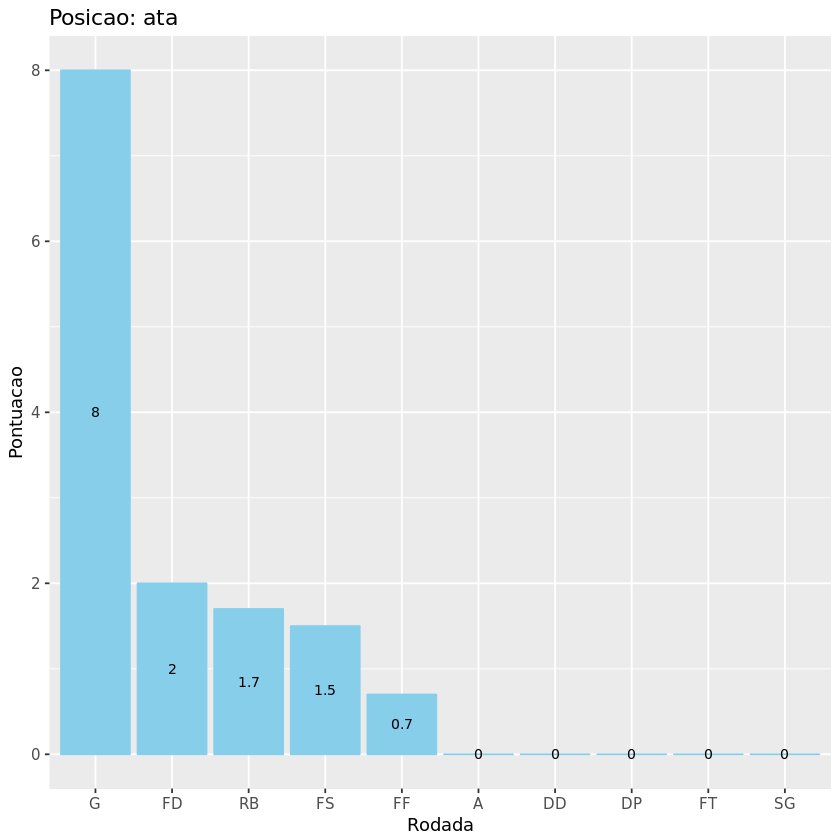

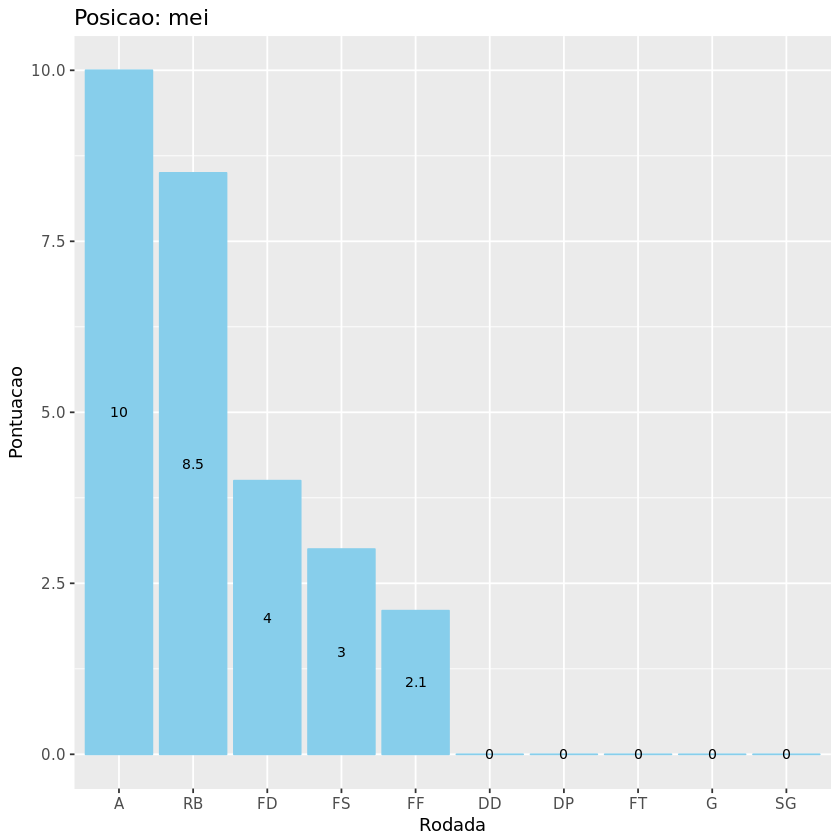

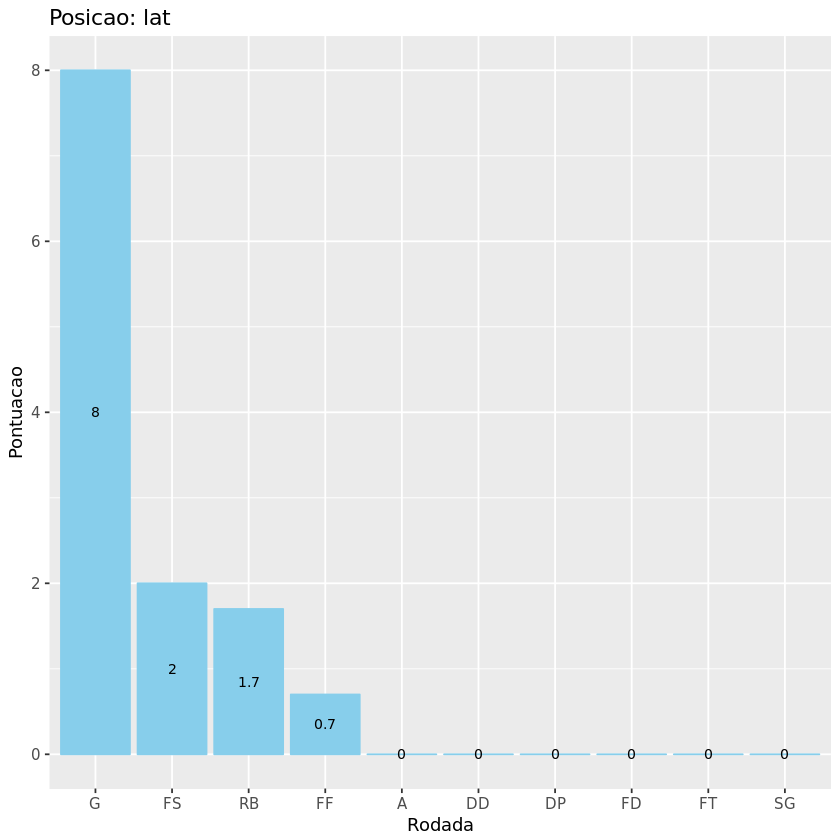

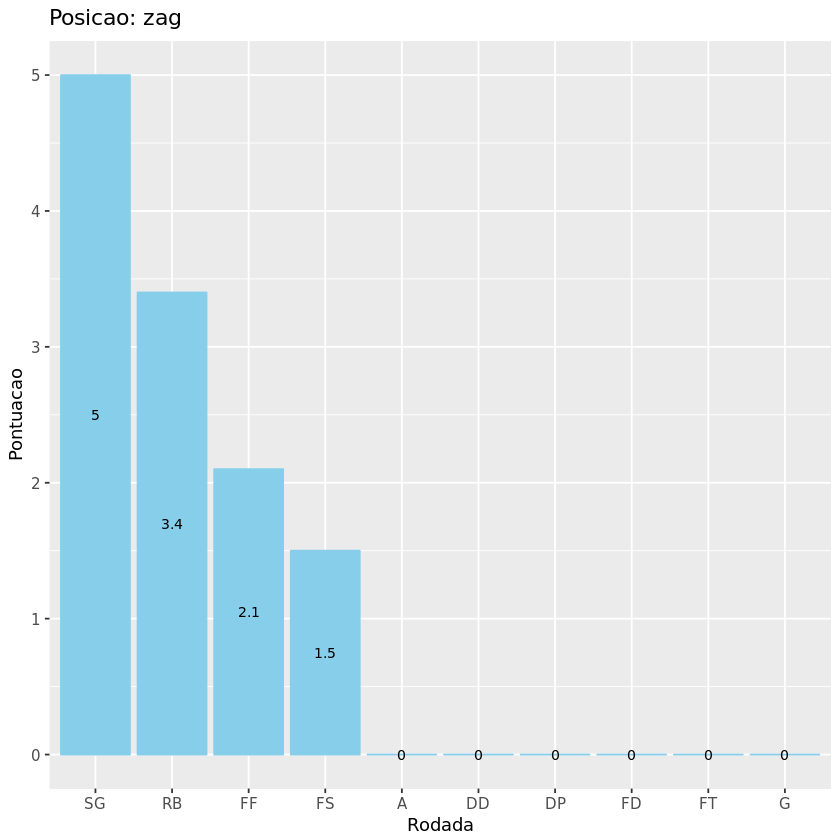

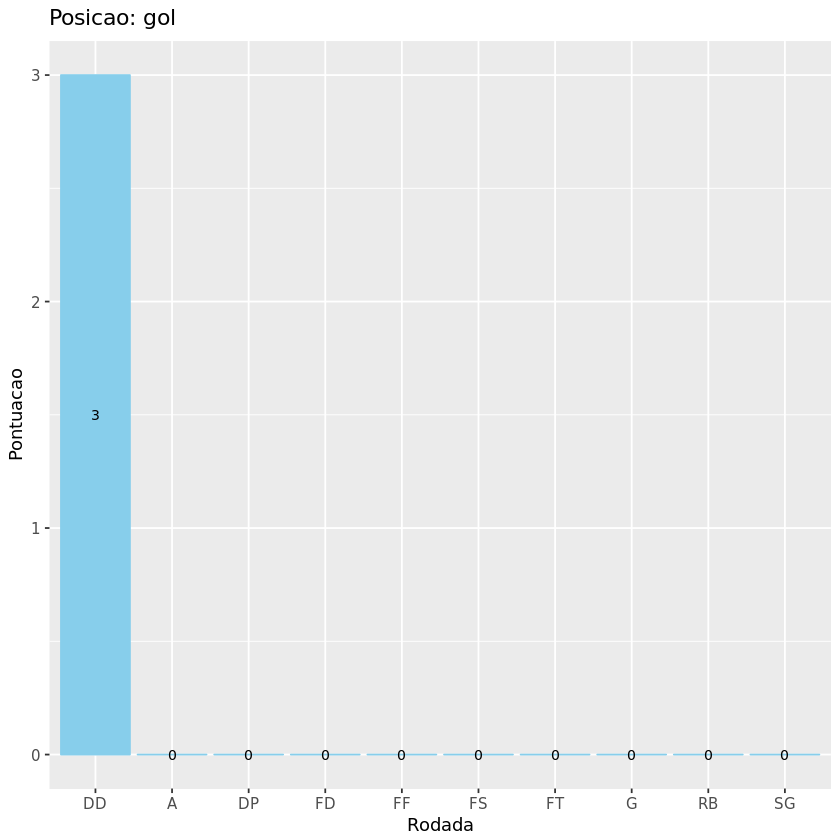

In [22]:
posic <- c("ata", "mei", "lat", "zag", "gol")

for (pos in posic){
    
 print( dados_time_cartoleiro %>%
  filter( rodada_id == rodada,
          posicao == pos ) %>% 
  select( posicao, FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  group_by( posicao ) %>% 
  summarise_each( funs(sum) ) %>% 
  gather( key = scout, value = qtd, -posicao ) %>% 
  right_join(., x = pontuacao_cartola, by = "scout" ) %>% 
  filter( valor > 0 ) %>% 
  mutate( pontos_por_scout = valor * qtd ) %>% 
  ggplot( aes( x = reorder( scout, -pontos_por_scout ), y = pontos_por_scout, label = pontos_por_scout ) ) +
  geom_bar( stat = "identity", color = "sky blue", fill = "sky blue" ) +
  geom_text( size = 3, position = position_stack(vjust = 0.5) ) +
  ylab( "Pontuacao" ) +
  xlab( "Rodada" ) +
  ggtitle( paste0( "Posicao: ", pos ) ) )   
    
}

## Onde perdeu pontos por posição

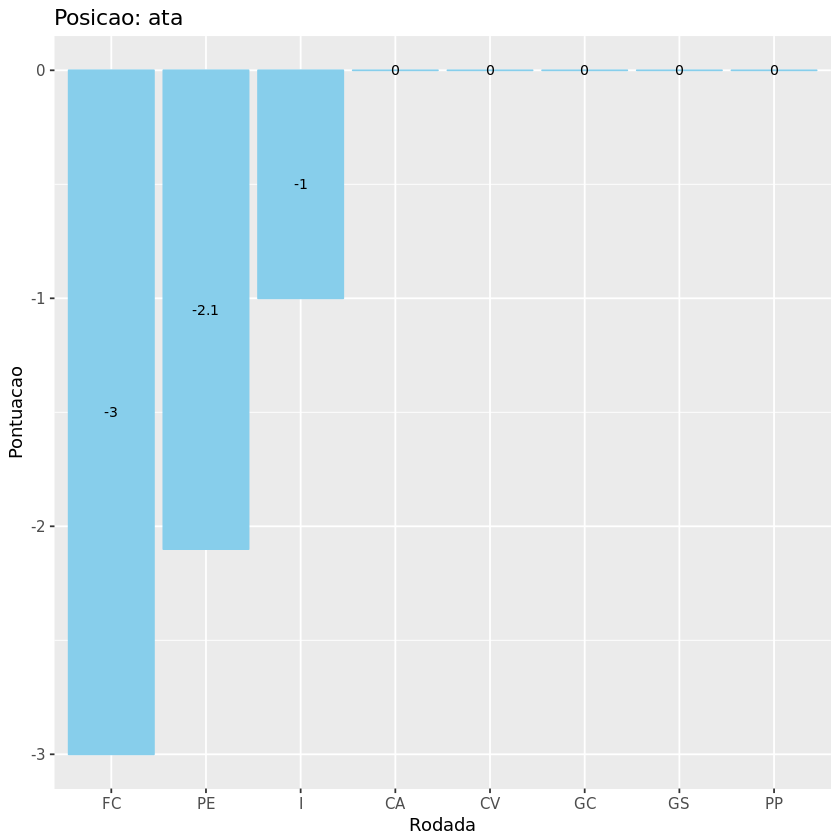

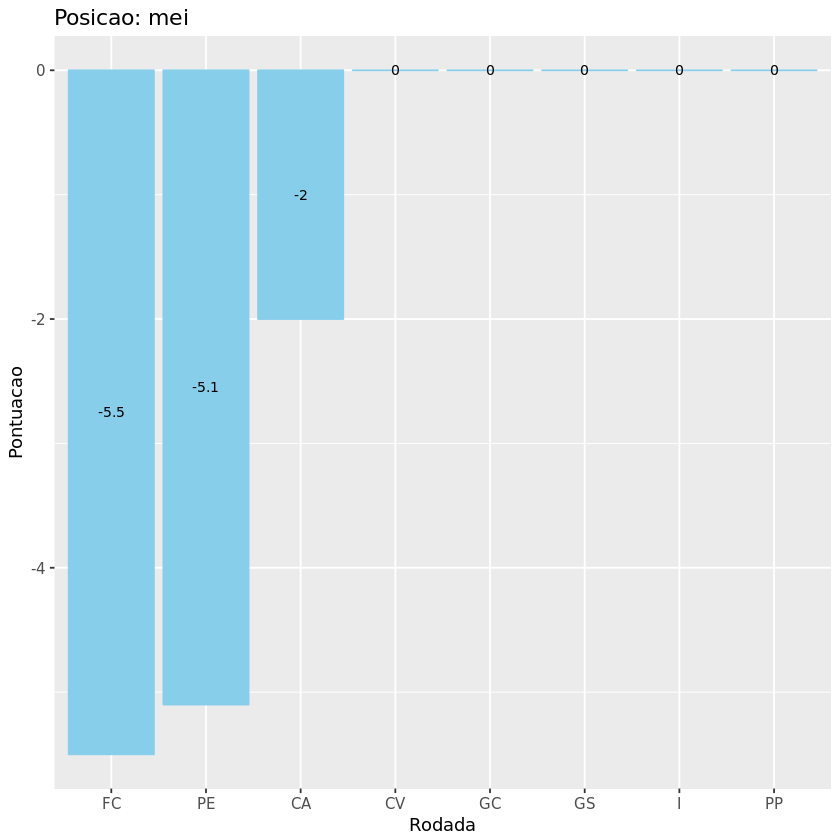

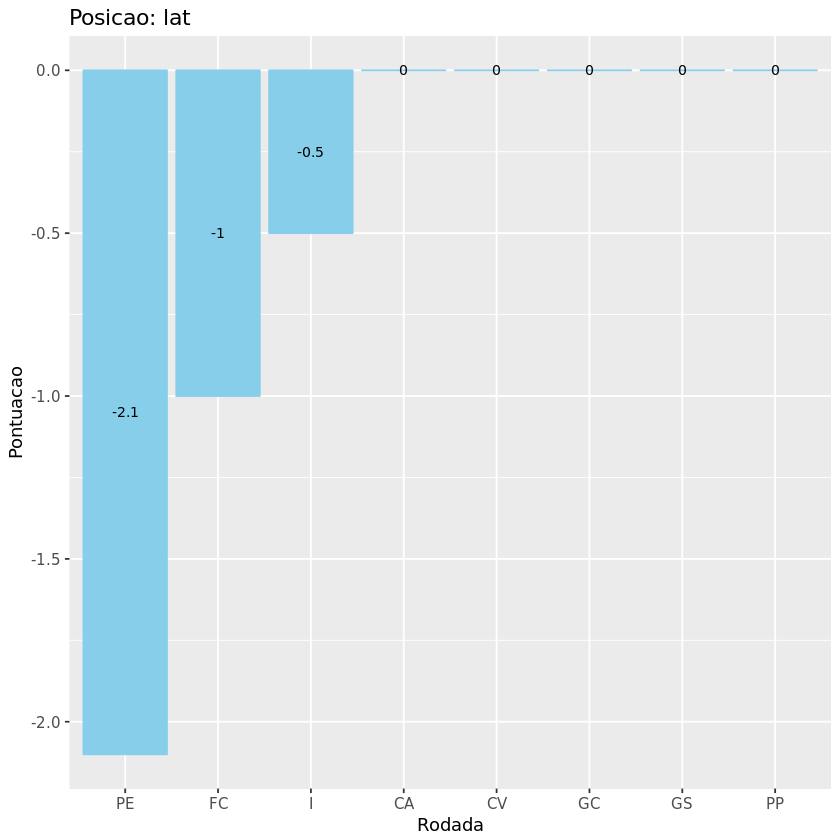

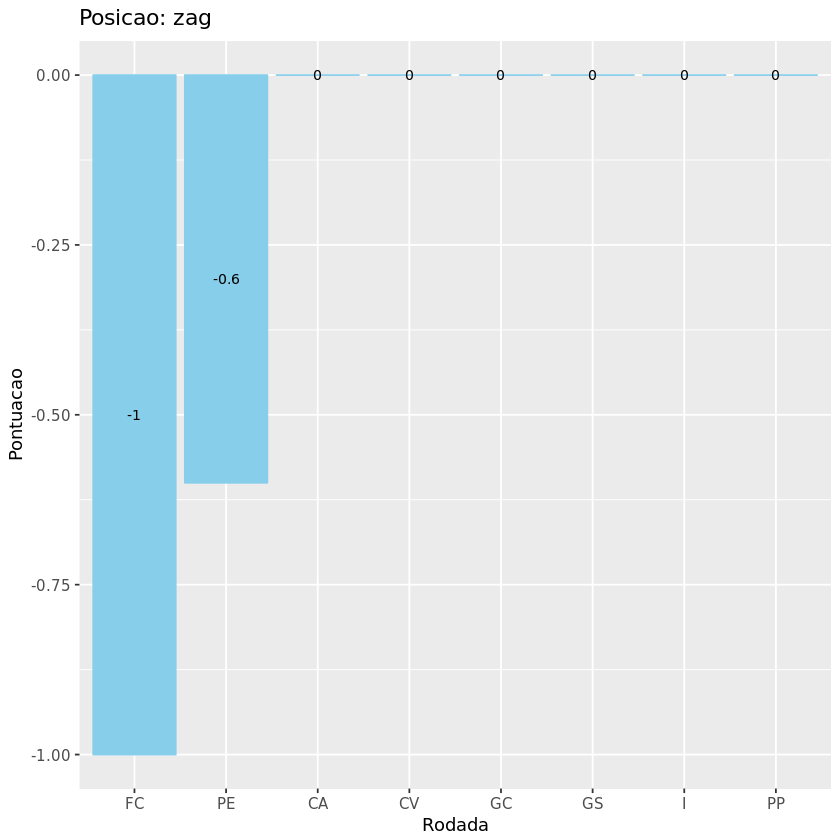

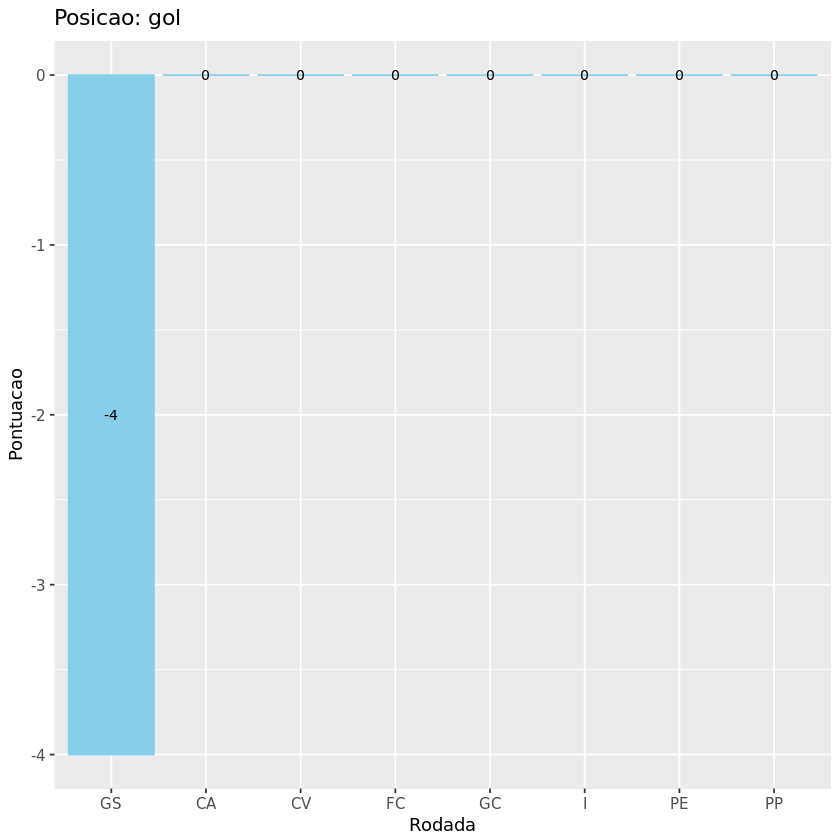

In [25]:
posic <- c("ata", "mei", "lat", "zag", "gol")

for (pos in posic){
    
 print( dados_time_cartoleiro %>%
  filter( rodada_id == rodada,
          posicao == pos ) %>% 
  select( posicao, FC, PE, RB, SG, CA, FD, FS, FF, I, G, DD, GS, A, CV, FT, GC, DP, PP ) %>% 
  group_by( posicao ) %>% 
  summarise_each( funs(sum) ) %>% 
  gather( key = scout, value = qtd, -posicao ) %>% 
  right_join(., x = pontuacao_cartola, by = "scout" ) %>% 
  filter( valor < 0 ) %>% 
  mutate( pontos_por_scout = valor * qtd ) %>% 
  ggplot( aes( x = reorder( scout, pontos_por_scout ) , y = pontos_por_scout, label = pontos_por_scout ) ) +
  geom_bar( stat = "identity", color = "sky blue", fill = "sky blue" ) +
  geom_text( size = 3, position = position_stack(vjust = 0.5) ) +
  ylab( "Pontuacao" ) +
  xlab( "Rodada" ) +
  ggtitle( paste0( "Posicao: ", pos ) ) )   
    
}